Trial 30 Complete [00h 02m 52s]
val_accuracy: 0.18459434807300568

Best val_accuracy So Far: 0.40747493505477905
Total elapsed time: 00h 35m 22s
Best Hyperparameters:  {'units_1': 384, 'dropout_1': 0.6000000000000001, 'units_2': 192, 'dropout_2': 0.5, 'units_3': 96, 'dropout_3': 0.4, 'learning_rate': 0.00045454167020149807, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0013'}
Epoch 1/10
549/549 [==============================] - 22s 35ms/step - loss: 1.3411 - accuracy: 0.6689 - val_loss: 2.8913 - val_accuracy: 0.4116
Epoch 2/10
549/549 [==============================] - 18s 33ms/step - loss: 1.2525 - accuracy: 0.6878 - val_loss: 2.9644 - val_accuracy: 0.4088
Epoch 3/10
549/549 [==============================] - 19s 34ms/step - loss: 1.1799 - accuracy: 0.7058 - val_loss: 2.9544 - val_accuracy: 0.4166
Epoch 4/10
549/549 [==============================] - 18s 33ms/step - loss: 1.1136 - accuracy: 0.7194 - val_loss: 3.0246 - val_accur

C:\Users\rishi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rishi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rishi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


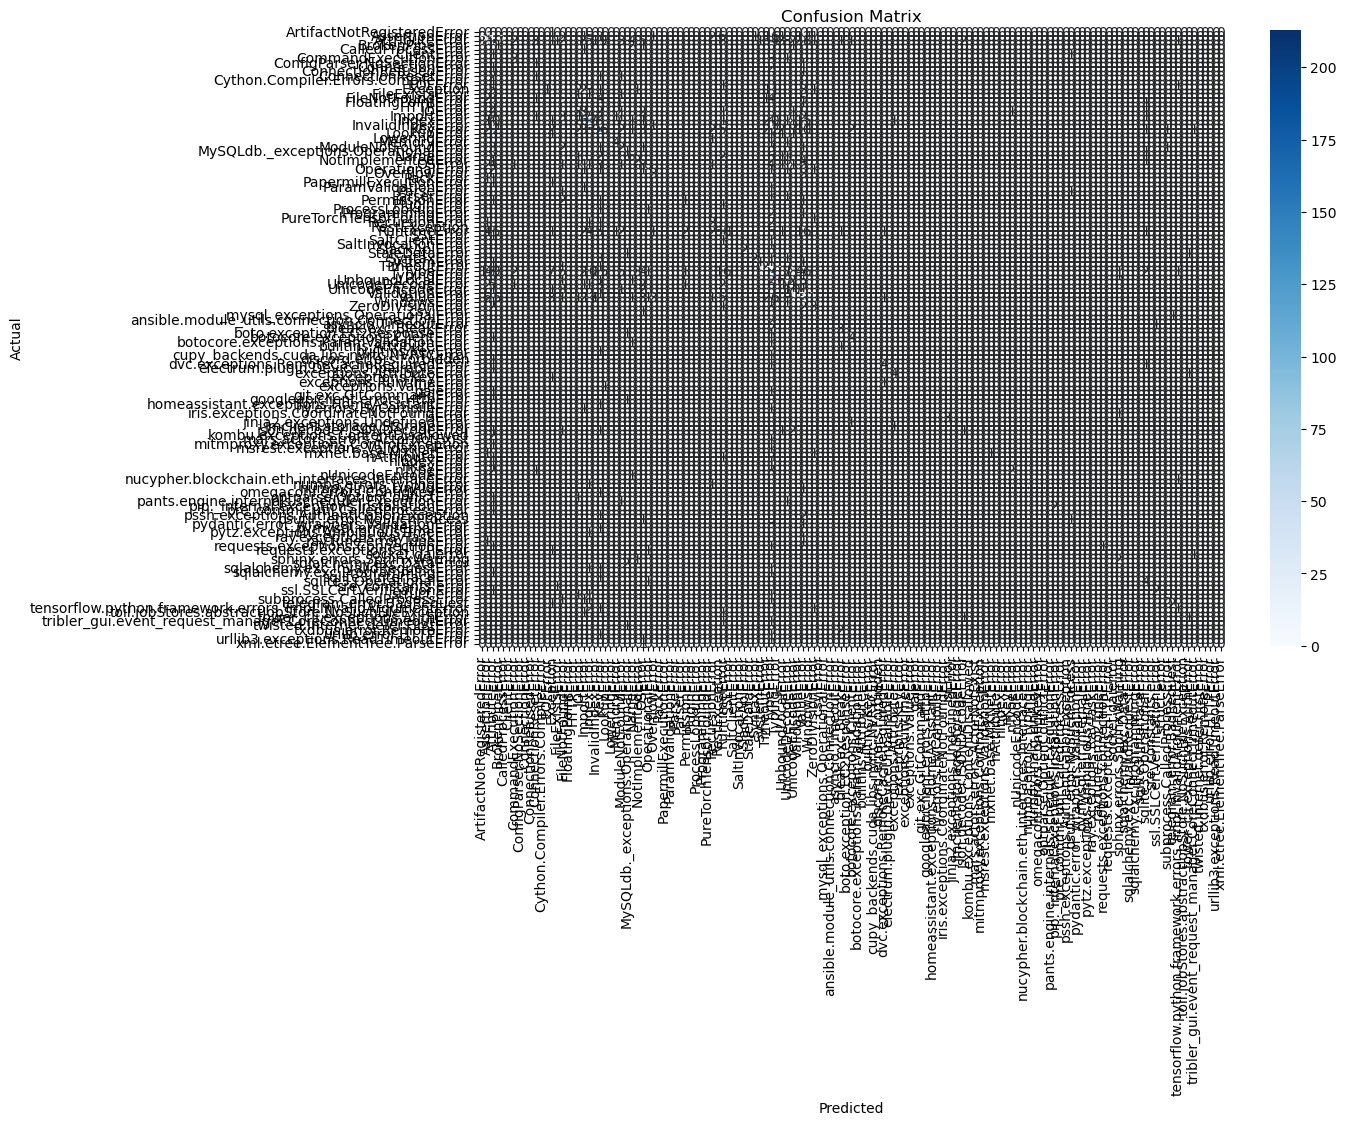

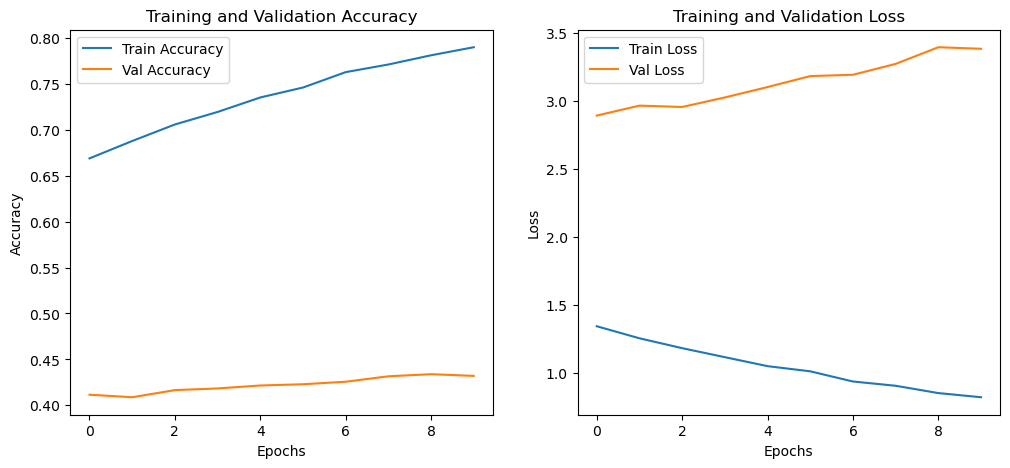

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
import keras_tuner as kt
import numpy as np

# Load the datasets
file_path = 'C://Users//rishi//Downloads//pytracebugs_dataset_v1//buggy_dataset//bugfixes_train.pickle'
file_path1 = 'C://Users//rishi//Downloads//pytracebugs_dataset_v1//buggy_dataset//bugfixes_test.pickle'
file_path2 = 'C://Users//rishi//Downloads//pytracebugs_dataset_v1//buggy_dataset//bugfixes_valid.pickle'

data = pd.read_pickle(file_path)
data1 = pd.read_pickle(file_path1)
data2 = pd.read_pickle(file_path2)

# Combine datasets into one DataFrame
df = pd.concat([data, data2, data1], ignore_index=True)

# Remove error types with fewer than 10 occurrences
error_counts = df['traceback_type'].value_counts()
df = df[df['traceback_type'].isin(error_counts[error_counts >= 10].index)]

# Prepare features and labels
X = df['before_merge']  # Features (code snippets)
y = df['traceback_type']  # Labels

# Stratified split for train/validation/test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Vectorization: Convert text to numerical vectors
vectorizer = TfidfVectorizer(max_features=10000)
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)

# Convert sparse matrices to dense format
X_train_vec_dense = X_train_vec.toarray()
X_val_vec_dense = X_val_vec.toarray()
X_test_vec_dense = X_test_vec.toarray()

# Label encoding for target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Function to build the model
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_1', min_value=128, max_value=512, step=128),
                    input_dim=X_train_vec_dense.shape[1], activation='relu'))
    model.add(Dropout(hp.Float('dropout_1', min_value=0.4, max_value=0.7, step=0.1)))
    model.add(Dense(units=hp.Int('units_2', min_value=64, max_value=256, step=64), activation='relu'))
    model.add(Dropout(hp.Float('dropout_2', min_value=0.4, max_value=0.7, step=0.1)))
    model.add(Dense(units=hp.Int('units_3', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout_3', min_value=0.4, max_value=0.7, step=0.1)))
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='LOG')),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Initialize Keras Tuner
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='kt_dir',
                     project_name='bug_traceback')

# Hyperparameter search
tuner.search(X_train_vec_dense, y_train_encoded, epochs=10, batch_size=32, validation_data=(X_val_vec_dense, y_val_encoded))

# Retrieve the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters: ", best_hyperparameters.values)

# Train the best model
history = best_model.fit(X_train_vec_dense, y_train_encoded, epochs=10, batch_size=32,
                         validation_data=(X_val_vec_dense, y_val_encoded))

# Evaluate the model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test_vec_dense, y_test_encoded)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Predict and evaluate
y_pred_encoded = best_model.predict(X_test_vec_dense)
y_pred = label_encoder.inverse_transform(np.argmax(y_pred_encoded, axis=1))

# Generate classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=label_encoder.classes_)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Training/Validation Accuracy and Loss Curves
def plot_training_curves(history):
    plt.figure(figsize=(12, 5))
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_training_curves(history)
